<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exercise%20Solutions/%F0%9F%9B%A0_06_Transfer_Learning_in_TensorFlow_Part_3_Scaling_up_Exercise_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercise Solutions 


1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

2. Recreate the first model (the feature extraction model) with mixed_precision turned on.
  - Does it make the model train faster?
  - Does it effect the accuracy or performance of our model?
  - What's the advatanges of using mixed_precision training?
  
3. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁 . 

**Note: ** Using Mixed precision eith EfficientNetB0 model will throw you an error. The error happens when you turn on mixed precision training for    EfficientNetBX models (if you're not sure what this is, you'll see it in the next video).

It'll look something like this:

```TypeError: Input 'y' of 'Sub' Op has type float16 that does not match type float32 of argument 'x' ```

As of 29 May 2021 it looks like this is a bug in TensorFlow 2.5+.

There is an issue thread tracking the progress of an update on GitHub: https://github.com/tensorflow/tensorflow/issues/49725

**Solution**

The current workaround is to **downgrade** to TensorFlow 2.4.1 (the last version before 2.5).

You can do this in Google Colab by running:
```
# Downgrade Tensorflow Version (run this in Google Colab) 
!pip install tensorflow==2.4.1
```
After doing so, you'll have to restart your runtime (Runtime -> Restart runtime) to ensure TensorFlow 2.4.1 is active.


```
# Check if TensorFlow 2.4.1 is active 
import tensorflow as tf
tf.__version__

>>> '2.4.1'
```

Once TensorFlow 2.4.1 is installed, the code should work as normal.

If you have any issues, please post your question/reply below so others can see.

If a fix for this issue comes for TensorFlow 2.5+ (it should), we'll update this post.

Happy mixed precision training,

To read the detailed thread: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/82

In [1]:
# Downgrading tensorflow to 2.4.1 

!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 39kB/s 
     |████████████████████████████████| 471kB 48.3MB/s 
     |████████████████████████████████| 2.9MB 42.2MB/s 
     |████████████████████████████████| 3.8MB 33.9MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


## Getting the data and a model readdy

In [2]:
# Getting the helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

--2021-07-16 11:35:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-16 11:35:11 (91.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2021-07-16 11:35:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.208, 142.251.33.208, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [3]:
# Importing the packages we need 
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [4]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Building a model to compare with 
base_model_0 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_0.trainable = False 

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape= (224 , 224 , 3) , name='input_layer')
x = base_model_0(inputs , training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_2D')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation= 'softmax', name = 'output_layer')(x)

# Packing into a model 
model_0 = tf.keras.Model(inputs , outputs , name = 'model_0')
model_0.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2D (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [7]:
# Compiling the model
model_0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit the model 
history_model_0 = model_0.fit(train_data_all_10_percent,
                                           epochs=5, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5
237/237 [==============================] - 85s 202ms/step - loss: 3.7850 - accuracy: 0.1957 - val_loss: 2.4063 - val_accuracy: 0.4740
Epoch 2/5
237/237 [==============================] - 47s 195ms/step - loss: 1.9215 - accuracy: 0.5932 - val_loss: 2.0266 - val_accuracy: 0.5169
Epoch 3/5
237/237 [==============================] - 47s 196ms/step - loss: 1.4550 - accuracy: 0.6719 - val_loss: 1.8708 - val_accuracy: 0.5334
Epoch 4/5
237/237 [==============================] - 47s 196ms/step - loss: 1.2050 - accuracy: 0.7277 - val_loss: 1.7954 - val_accuracy: 0.5418
Epoch 5/5
237/237 [==============================] - 47s 195ms/step - loss: 1.0208 - accuracy: 0.7761 - val_loss: 1.7618 - val_accuracy: 0.5426


In [13]:
# Evaluating the model 
results_feature_extraction_model_0 = model_0.evaluate(test_data)
results_feature_extraction_model_0

790/790 [==============================] - 107s 135ms/step - loss: 1.5922 - accuracy: 0.6063


[1.592247724533081, 0.606257438659668]

In [14]:
base_model_0.trainable = True 

# Refreeze every layer except for the last 7 
for layer in base_model_0.layers[:-7]:
  layer.trainable = False

In [15]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_0.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [16]:
# Recompiling the model 
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001 / 10) , 
                metrics = ['accuracy'])

In [17]:
# Fine-tune for 5 more epochs
initial_epochs = 5
fine_tune_epochs = 5 + initial_epochs # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_model_0_fine_tune = model_0.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_model_0.epoch[-1]) 

Epoch 5/10
237/237 [==============================] - 54s 206ms/step - loss: 0.2522 - accuracy: 0.9605 - val_loss: 1.9375 - val_accuracy: 0.5482
Epoch 6/10
237/237 [==============================] - 48s 201ms/step - loss: 0.1941 - accuracy: 0.9721 - val_loss: 1.9648 - val_accuracy: 0.5522
Epoch 7/10
237/237 [==============================] - 48s 201ms/step - loss: 0.1540 - accuracy: 0.9829 - val_loss: 2.0303 - val_accuracy: 0.5487
Epoch 8/10
237/237 [==============================] - 48s 200ms/step - loss: 0.1210 - accuracy: 0.9908 - val_loss: 2.0511 - val_accuracy: 0.5516
Epoch 9/10
237/237 [==============================] - 48s 202ms/step - loss: 0.0941 - accuracy: 0.9948 - val_loss: 2.1201 - val_accuracy: 0.5490
Epoch 10/10
237/237 [==============================] - 48s 201ms/step - loss: 0.0726 - accuracy: 0.9985 - val_loss: 2.1967 - val_accuracy: 0.5469


In [18]:
# Evaluating the model results 

results_fine_tune_model_0 = model_0.evaluate(test_data)
results_fine_tune_model_0

790/790 [==============================] - 108s 137ms/step - loss: 1.8534 - accuracy: 0.6010


[1.8533722162246704, 0.6009504795074463]

Alright now we got a model to compare, let's begin our exercise! 

### 1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [19]:
# Building the feature extractor model
base_model_1 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_1.trainable = False 

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape= (224 , 224 , 3) , name='input_layer')
x = base_model_1(inputs , training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_2D')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation= 'softmax', name = 'output_layer')(x)

# Packing into a model 
feature_extractor_model = tf.keras.Model(inputs , outputs , name = 'feature_extractor_model')
feature_extractor_model.summary() 

Model: "feature_extractor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2D (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [20]:
# Compiling the feature extractor model 
feature_extractor_model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                                optimizer = tf.keras.optimizers.Adam() , 
                                metrics = ['accuracy'])

# Fitting the feature extractor model for 10 epochs
history_feature_extractor_model = feature_extractor_model.fit(train_data_all_10_percent,
                                           epochs=10, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data))) 

Epoch 1/10
237/237 [==============================] - 55s 206ms/step - loss: 3.7676 - accuracy: 0.1992 - val_loss: 2.4626 - val_accuracy: 0.4499
Epoch 2/10
237/237 [==============================] - 48s 201ms/step - loss: 1.9185 - accuracy: 0.5791 - val_loss: 2.0441 - val_accuracy: 0.5154
Epoch 3/10
237/237 [==============================] - 48s 201ms/step - loss: 1.4653 - accuracy: 0.6679 - val_loss: 1.8590 - val_accuracy: 0.5355
Epoch 4/10
237/237 [==============================] - 48s 201ms/step - loss: 1.2052 - accuracy: 0.7302 - val_loss: 1.8155 - val_accuracy: 0.5360
Epoch 5/10
237/237 [==============================] - 48s 201ms/step - loss: 1.0203 - accuracy: 0.7785 - val_loss: 1.7783 - val_accuracy: 0.5400
Epoch 6/10
237/237 [==============================] - 48s 202ms/step - loss: 0.8897 - accuracy: 0.8190 - val_loss: 1.7334 - val_accuracy: 0.5453
Epoch 7/10
237/237 [==============================] - 48s 202ms/step - loss: 0.7690 - accuracy: 0.8483 - val_loss: 1.7297 - val_ac

In [21]:
# Evaluating the feature extractor model on test data 
feature_extractor_results = feature_extractor_model.evaluate(test_data)
feature_extractor_results 

790/790 [==============================] - 109s 137ms/step - loss: 1.4824 - accuracy: 0.6061


[1.4823750257492065, 0.6061385869979858]

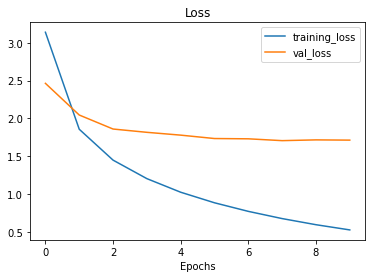

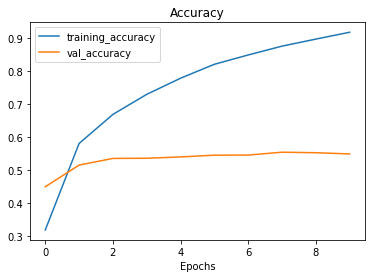

In [22]:
plot_loss_curves(history_feature_extractor_model)

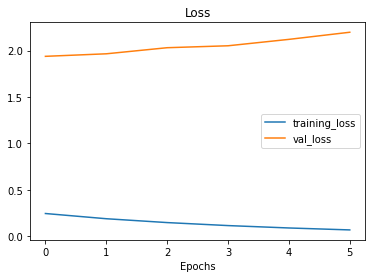

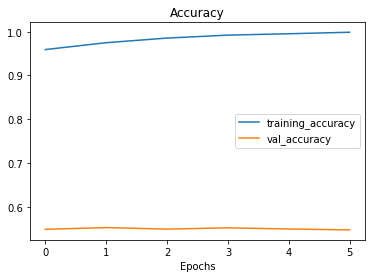

In [23]:
plot_loss_curves(history_model_0_fine_tune)

Looking at the loss curves we can say that the **feature extractor model** which was trained for 10 epochs performing better than the **fine tune model**. 

Though the results might get worse if we fine tune the feature extractor model.

### 2. Recreate the first model (the feature extraction model) with mixed_precision turned on.

In [24]:
# Set global policy to mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [25]:
class_names = train_data_all_10_percent.class_names

In [26]:
# Building a model with mixed precision 

# Create base model
input_shape = (224, 224, 3)
base_model_fp = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_fp.trainable = False 

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model_fp(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
mixed_pre_model = tf.keras.Model(inputs, outputs)

# Compile the model
mixed_pre_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [27]:
# Summary of the model 
mixed_pre_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [28]:
initial_epochs


5

In [29]:
# Fitting the feature extractor model for 5 epochs                                          
history_mixed_feature_extractor = mixed_pre_model.fit(train_data_all_10_percent , 
                                                      epochs= initial_epochs, 
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)))

Epoch 1/5
237/237 [==============================] - 51s 190ms/step - loss: 3.7659 - accuracy: 0.1993 - val_loss: 2.4225 - val_accuracy: 0.4656
Epoch 2/5
237/237 [==============================] - 44s 184ms/step - loss: 1.9215 - accuracy: 0.5805 - val_loss: 2.0560 - val_accuracy: 0.5019
Epoch 3/5
237/237 [==============================] - 44s 183ms/step - loss: 1.4544 - accuracy: 0.6755 - val_loss: 1.9009 - val_accuracy: 0.5201
Epoch 4/5
237/237 [==============================] - 44s 185ms/step - loss: 1.2018 - accuracy: 0.7248 - val_loss: 1.8285 - val_accuracy: 0.5312
Epoch 5/5
237/237 [==============================] - 44s 184ms/step - loss: 1.0222 - accuracy: 0.7755 - val_loss: 1.7676 - val_accuracy: 0.5410


In [30]:
# Unfreezing the layers for fine tuning the model 
base_model_fp.trainable = True 

# Refreeze every layer except for the last 7 
for layer in base_model_fp.layers[:-5]:
  layer.trainable = False

In [31]:
# Re-compiling the model 
mixed_pre_model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001) , 
                        metrics = ['accuracy'])

In [32]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_fp.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [33]:
# Fine tuning the model for another 5 epochs 
fine_tune_epochs = initial_epochs + 5                                    
history_mixed_model_fine_tune = mixed_pre_model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_mixed_feature_extractor.epoch[-1]) 

Epoch 5/10
237/237 [==============================] - 51s 191ms/step - loss: 0.7952 - accuracy: 0.8197 - val_loss: 1.7345 - val_accuracy: 0.5530
Epoch 6/10
237/237 [==============================] - 44s 184ms/step - loss: 0.6214 - accuracy: 0.8539 - val_loss: 1.7504 - val_accuracy: 0.5543
Epoch 7/10
237/237 [==============================] - 44s 185ms/step - loss: 0.5337 - accuracy: 0.8797 - val_loss: 1.7703 - val_accuracy: 0.5564
Epoch 8/10
237/237 [==============================] - 44s 184ms/step - loss: 0.4586 - accuracy: 0.9005 - val_loss: 1.8039 - val_accuracy: 0.5561
Epoch 9/10
237/237 [==============================] - 44s 185ms/step - loss: 0.3898 - accuracy: 0.9205 - val_loss: 1.8105 - val_accuracy: 0.5561
Epoch 10/10
237/237 [==============================] - 44s 185ms/step - loss: 0.3393 - accuracy: 0.9332 - val_loss: 1.8379 - val_accuracy: 0.5543


- **Does it make the model train faster?**
    
  Not much, but it saved us some seconds. 

- **Does it effect the accuracy or performance of our model?**

  By 1% not that much tho. 
- **What's the advatanges of using mixed_precision training?**

  The advantages of mixed precision is evident when we are training pretty big models for longer epochs. In that case, we can spot a huge difference in our training time. 



### 3. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.

Now its upto you guys to make predictions with your custom picture and share the results on Discord. Good Luck. 

> **Note:** This is just a simple template for the solution and there is always room for improvements. 